In [1]:
import os

os.chdir("..")
# print(os.getcwd()) 

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from Models import Generators, Discriminators, LossFunctions
import Models.utils as utils

from Processing.CategoricalProcessing import CategoricalToNumericalNorm as c2nn

In [3]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
df = df.dropna()

category_inter = c2nn.create_category_intervals(df["BodyTemp"].values)

df["BodyTemp_numeric"] = df["BodyTemp"].apply(lambda x: c2nn.generate_number(x, category_inter))


numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp_numeric', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

In [4]:
class EncoderDecoderCNN1D(nn.Module):
    def __init__(self, input_dim, num_layers=3, initial_filter=256, latent_dim=16, kernel_size=3):
        super(EncoderDecoderCNN1D, self).__init__()
        
        if latent_dim is None:
            latent_dim = initial_filter // (2 ** (num_layers - 1))
        
        # ###############
        # ### Encoder ###
        # ###############
        encoder_list = []
        for i in range(num_layers):
            if i == 0:
                encoder_list.extend(self.custom_conv_block(input_dim, initial_filter, kernel_size=kernel_size))
                filter = initial_filter
            else:
                encoder_list.extend(self.custom_conv_block(filter, filter // 2, kernel_size=kernel_size))
                filter //= 2
        
        encoder_list.extend(self.custom_conv_block(filter, latent_dim, kernel_size=kernel_size))
        
        self.encoder = nn.Sequential(*encoder_list)
        
        # ###############
        # ### Decoder ###
        # ###############
        decoder_filter = latent_dim
        decoder_list = []
        for _ in range(num_layers):
            decoder_list.extend(self.custom_deconv_block(decoder_filter, 2 * decoder_filter, kernel_size=kernel_size))
            decoder_filter *= 2

        
        decoder_list.extend(self.custom_conv_block(decoder_filter, input_dim, kernel_size=kernel_size))
        decoder_list.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*decoder_list)

    @staticmethod
    def custom_conv_block(input_dim, output_dim, kernel_size=5, dropout_rate=0.1):
        return [
            nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size, padding=1, stride=1), 
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        ]
    
    @staticmethod
    def custom_deconv_block(input_dim, output_dim, kernel_size=5, dropout_rate=0.1):
        return [
            nn.ConvTranspose1d(input_dim, output_dim, kernel_size=kernel_size, stride=2, padding=1, output_padding=0), 
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        ]
    
    def forward(self, z):
        latent_output = self.encoder(z)
        output = self.decoder(latent_output)
        return output


generator = EncoderDecoderCNN1D(input_dim=data_dim)
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)

In [5]:
discriminator = Discriminators.Discriminator(input_dim=data_dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)

# Loss function
criterion = nn.BCELoss()

In [6]:
t0 = time.time()

num_epochs = 8000
batch_size = 500

all_real_data_torch = torch.tensor(data, dtype=torch.float32)

save_nn_data_list = []
for epoch in range(num_epochs):
    
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    # Generar datos falsos
    z = torch.randn(batch_size, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    z_reshape = z_minmax.reshape(batch_size, data_dim, 1)
    fake_data_reshape = generator(z_reshape)
    fake_data = fake_data_reshape.reshape(batch_size, data_dim)
    
    if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
        print("Fake data contains NaNs or Infs!")
        break

    if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
        print("Real data contains NaNs or Infs!")
        break
    
    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = LossFunctions.custom_loss(fake_data, real_data, method="corrmat-covmat-integral")
    g_loss.backward()
    # g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        save_nn_data_list.append({
            "epoch": epoch,
            "discriminator_loss": d_loss.item(),
            "generator_loss": g_loss.item()
        })

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        if utils.stop_training_func(save_nn_data_list, epoch_dist=1000):
                break

print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

df_nn = pd.DataFrame(save_nn_data_list)

training_time = time.time() - t0

print("Training time", np.round((training_time)/60, 4), "min")

Epoch 0, D Loss: 1.7034003734588623, G Loss: 10.424561500549316
Epoch 500, D Loss: 1.4189422130584717, G Loss: 6.083981513977051
Epoch 1000, D Loss: 1.3686203956604004, G Loss: 5.312737464904785
Epoch 1500, D Loss: 1.2632603645324707, G Loss: 5.778510570526123
Epoch 2000, D Loss: 1.1919362545013428, G Loss: 5.129054069519043
Epoch 2500, D Loss: 1.084529995918274, G Loss: 5.387175559997559
Epoch 3000, D Loss: 0.9581916928291321, G Loss: 5.236311912536621
Epoch 3001, D Loss: 0.9581916928291321, G Loss: 5.236311912536621
Training time 5.964 min


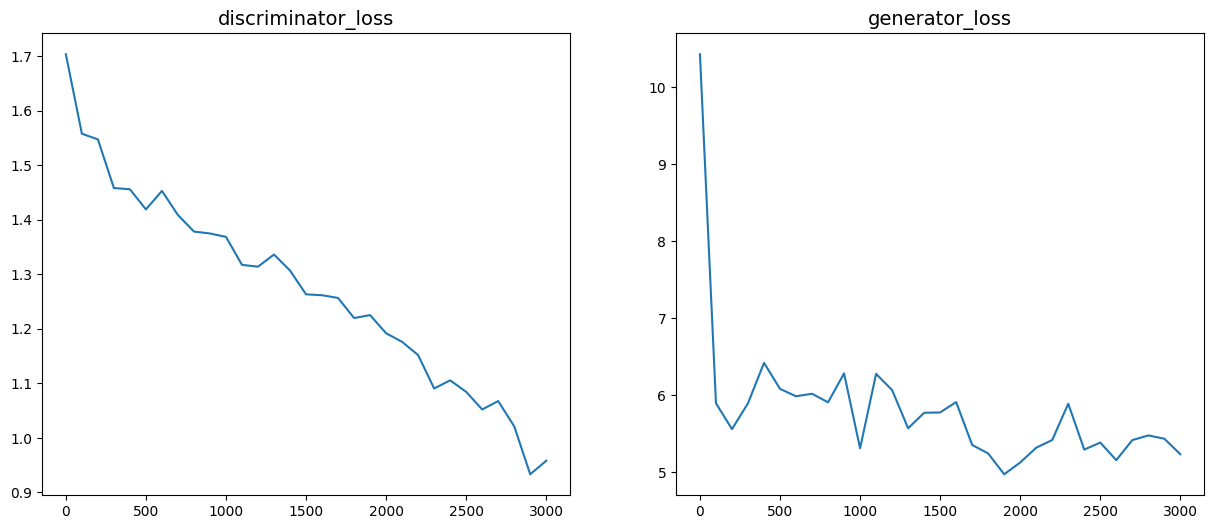

In [7]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [8]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp_numeric', 'HeartRate']
sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df[numeric_cols])
print(sdv_metadata.to_dict())

{'columns': {'Age': {'sdtype': 'numerical'}, 'SystolicBP': {'sdtype': 'numerical'}, 'DiastolicBP': {'sdtype': 'numerical'}, 'BS': {'sdtype': 'numerical'}, 'BodyTemp_numeric': {'sdtype': 'numerical'}, 'HeartRate': {'sdtype': 'numerical'}}, 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1'}


In [9]:
custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float",
    "BodyTemp_numeric": "float",
    "HeartRate": "integer",
}

z = torch.randn(500, data_dim, 1)
z_minmax = (z - z.min()) / (z.max() - z.min())
synthetic_data_reshape = generator(z_minmax).detach().numpy()
synthetic_data = synthetic_data_reshape.reshape(500, data_dim)

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)


custom_syn_df = synthetic_df.copy()

for col_name, col_type in custom_metadata_dict.items():
    if col_type == "integer":
        custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

In [10]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    sdv_metadata
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 23.55it/s]


Overall Quality Score: 69.37%

Properties:
Column Shapes: 40.9%
Column Pair Trends: 97.84%


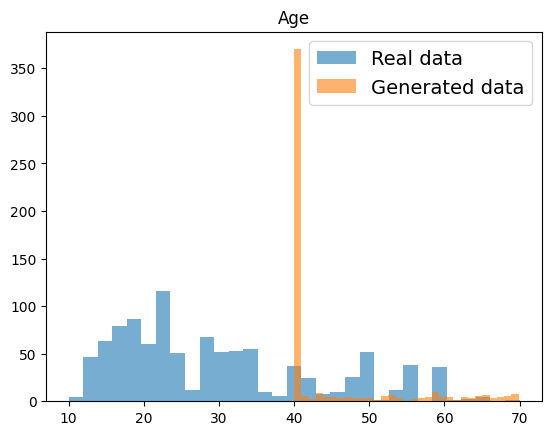

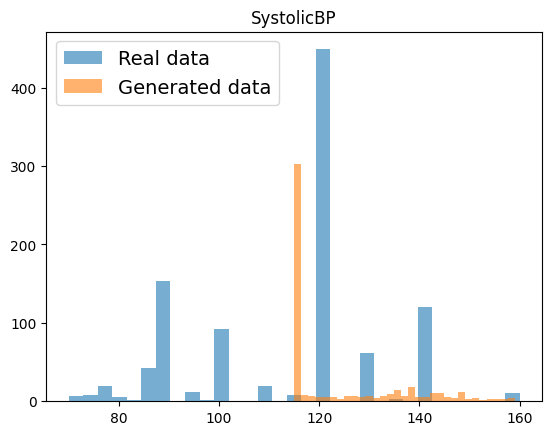

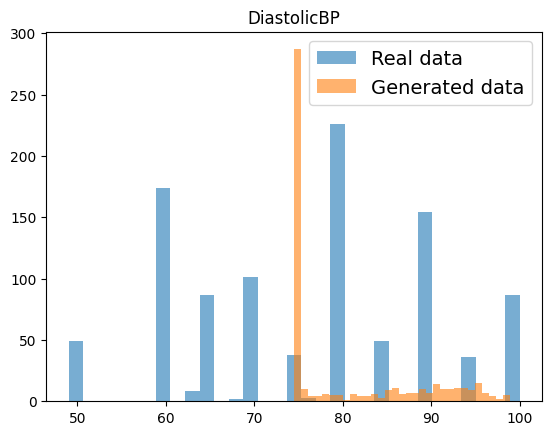

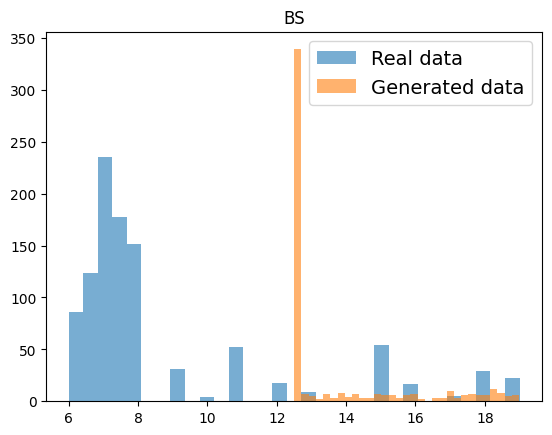

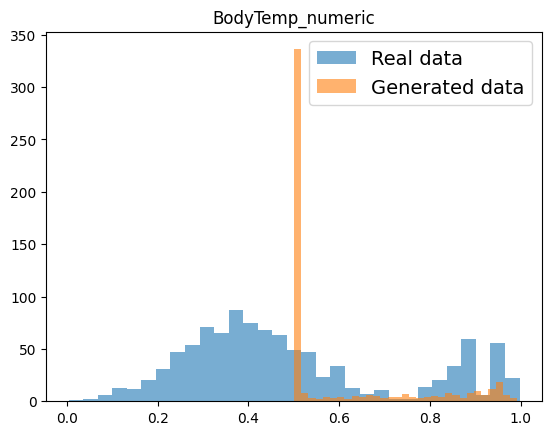

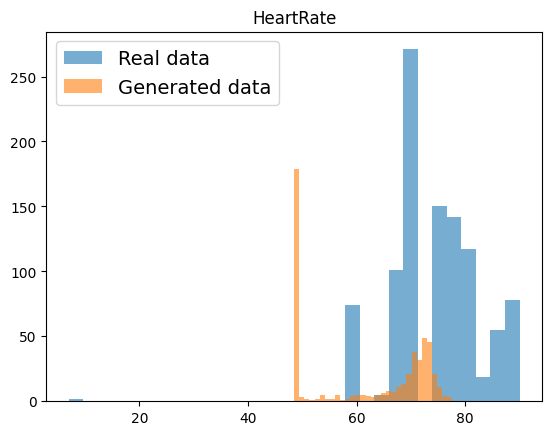

In [11]:
for col in numeric_cols:

    plt.hist(df[col].values, bins=31, alpha=0.6, label="Real data")
    plt.hist(synthetic_df[col].values, bins=31, alpha=0.6, label="Generated data")
    plt.title(col, fontsize=12)
    plt.legend(fontsize=14)
    
    plt.show()

# Make a loop

In [13]:
import itertools
from collections import defaultdict

import sklearn.metrics as skm

from sdv.single_table import GaussianCopulaSynthesizer

In [14]:
def generate_combinations(elements, sizes):
    comb_list = []
    for size in sizes:
        comb_list.extend(list(itertools.combinations(elements, size)))
    return comb_list

In [15]:
loss_method = ["median", "iqr", "corrmat", "covmat", "integral"]
sizes = np.arange(2, 3+1)
all_comb_list = generate_combinations(loss_method, sizes)
loss_method_list = ["-".join(x) for x in all_comb_list]
loss_method_list.extend(loss_method + ["all"])
print(loss_method_list)
print("Number of methods", len(loss_method_list))

['median-iqr', 'median-corrmat', 'median-covmat', 'median-integral', 'iqr-corrmat', 'iqr-covmat', 'iqr-integral', 'corrmat-covmat', 'corrmat-integral', 'covmat-integral', 'median-iqr-corrmat', 'median-iqr-covmat', 'median-iqr-integral', 'median-corrmat-covmat', 'median-corrmat-integral', 'median-covmat-integral', 'iqr-corrmat-covmat', 'iqr-corrmat-integral', 'iqr-covmat-integral', 'corrmat-covmat-integral', 'median', 'iqr', 'corrmat', 'covmat', 'integral', 'all']
Number of methods 26


In [16]:
from sdv.metadata import SingleTableMetadata

sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df)

In [21]:
def post_process_data_with_metadata(data, custom_metadata_dict):
    custom_syn_df = data.copy()
    for col_name, col_type in custom_metadata_dict.items():
        if col_type == "integer":
            custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

    return custom_syn_df

def generate_synthetic_data(generator, scaler, df_columns, num_data_generate, data_dim):
    """Generates synthetic data using a GAN-based generator and denormalizes it."""
    z = torch.randn(num_data_generate, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    z_reshape = z_minmax.reshape(num_data_generate, data_dim, 1)
    synthetic_data_reshape = generator(z_reshape).detach().numpy()
    synthetic_data = synthetic_data_reshape.reshape(num_data_generate, data_dim)
    synthetic_data_denom = scaler.inverse_transform(synthetic_data)
    
    return pd.DataFrame(synthetic_data_denom, columns=df_columns)

def evaluate_generator_metrics(real_df, synthetic_df, metadata=sdv_metadata):
    """Evaluates synthetic data quality using a quality report."""
    quality_report = evaluate_quality(real_df, synthetic_df, metadata, verbose=False)
    return quality_report.get_score()

def evaluate_discriminator_metrics(discriminator, real_data, fake_data, sigmoid_th, metrics_skm_dict):
    """Evaluates discriminator performance using real and synthetic data."""
    both_data_torch = torch.cat((real_data, fake_data), dim=0)
    
    true_labels = np.concatenate((np.zeros(real_data.shape[0]), np.ones(fake_data.shape[0])))
    discriminator_score = discriminator(both_data_torch)
    
    disc_score_array = (discriminator_score.detach().numpy()[:, 0] > sigmoid_th).astype(int)

    return {k: skm_func(true_labels, disc_score_array) for k, skm_func in metrics_skm_dict.items()}

def generate_sdv_synthetic_data(df, num_data_generate, metadata=sdv_metadata):
    """Generates synthetic data using SDV GaussianCopulaSynthesizer."""
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(data=df)
    return synthesizer.sample(num_rows=num_data_generate)

In [22]:
metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

num_epochs = 8000
batch_size = 500
num_generate_th = 30
num_data_generate = 500
sigmoid_th = 0.5

save_result_list = []

for i_m, loss_method in enumerate(loss_method_list[:]):

    print(i_m, loss_method)
    
    all_real_data_torch = torch.tensor(data, dtype=torch.float32)

    generator = EncoderDecoderCNN1D(input_dim=data_dim)
    optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)
    
    discriminator = Discriminators.Discriminator(input_dim=data_dim)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)
    
    criterion = nn.BCELoss()
    
    save_nn_data_list = []
    for epoch in range(num_epochs):
        
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data_array = data[idx]
        real_data = torch.tensor(data[idx], dtype=torch.float32)
        
        # Generar datos falsos
        z = torch.randn(batch_size, data_dim)
        z_minmax = (z - z.min()) / (z.max() - z.min())
        z_reshape = z_minmax.reshape(batch_size, data_dim, 1)
        fake_data_reshape = generator(z_reshape)
        fake_data = fake_data_reshape.reshape(batch_size, data_dim)
    
        if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
            print("Fake data contains NaNs or Infs!")
            break
    
        if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
            print("Real data contains NaNs or Infs!")
            break
        
        # Entrenar Discriminador
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
    
        # Entrenar Generador
        optimizer_g.zero_grad()
        g_loss = LossFunctions.custom_loss(fake_data, real_data, method=loss_method)
        g_loss.backward()
        # g_loss.backward()
        optimizer_g.step()

        if epoch % 100 == 0:
            save_nn_data_list.append({
                "epoch": epoch,
                "discriminator_loss": d_loss.item(),
                "generator_loss": g_loss.item()
            })

            if utils.stop_training_func(save_nn_data_list):
                break

    # #####################
    # ### Generate data ###
    # #####################
    metrics_dict = defaultdict(list)
    for _ in range(num_generate_th):
        # ########################
        # ### Custom Generator ###
        # ########################
        # Generate and process GAN-based synthetic data
        synthetic_df = generate_synthetic_data(generator, scaler, df.columns, num_data_generate, data_dim)
        custom_syn_df = post_process_data_with_metadata(synthetic_df, custom_metadata_dict)

        # Generator Metrics
        qr_score = evaluate_generator_metrics(df[numeric_cols], custom_syn_df)
        metrics_dict["qr_score"].append(qr_score)

        # Discriminator Metrics
        real_data_tensor = torch.tensor(data[np.random.randint(0, data.shape[0], num_data_generate)], dtype=torch.float32)
        fake_data_tensor = torch.tensor(synthetic_df.values, dtype=torch.float32)
        
        disc_metrics = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics.items():
            metrics_dict[k].append(v)

        # #####################
        # ### SDV Generator ###
        # #####################
        # Generate and process SDV-based synthetic data
        synthetic_df_sdv = generate_sdv_synthetic_data(df, num_data_generate)

        # Generator Metrics for SDV
        qr_score_sdv = evaluate_generator_metrics(df[numeric_cols], synthetic_df_sdv)
        metrics_dict["sdv_qr_score"].append(qr_score_sdv)

        # Discriminator Metrics for SDV
        fake_data_tensor_sdv = torch.tensor(synthetic_df_sdv.values, dtype=torch.float32)
        disc_metrics_sdv = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor_sdv, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics_sdv.items():
            metrics_dict[f"sdv_{k}"].append(v)

    del generator, discriminator, optimizer_g, optimizer_d, criterion
    
    dict_help = {"loss_method": loss_method}
    for k, v in metrics_dict.items():
        dict_help[f"mean_{k}"] = np.mean(v)
        if k != "sdv_qr_score": 
            dict_help[f"std_{k}"] = np.std(v)
        
    save_result_list.append(dict_help)

0 median-iqr
1 median-corrmat
2 median-covmat
3 median-integral
4 iqr-corrmat
5 iqr-covmat
6 iqr-integral
7 corrmat-covmat
8 corrmat-integral
9 covmat-integral
10 median-iqr-corrmat
11 median-iqr-covmat
12 median-iqr-integral
13 median-corrmat-covmat
14 median-corrmat-integral
15 median-covmat-integral
16 iqr-corrmat-covmat
17 iqr-corrmat-integral
18 iqr-covmat-integral
19 corrmat-covmat-integral
20 median
21 iqr
22 corrmat
23 covmat
24 integral
25 all


In [23]:
df_results = pd.DataFrame(save_result_list).sort_values("mean_qr_score", ascending=False).reset_index(drop=True)
df_results.head(10)

,loss_method,mean_qr_score,std_qr_score,mean_accuracy,std_accuracy,mean_kappa,std_kappa,mean_f1_score,std_f1_score,mean_sdv_qr_score,mean_sdv_accuracy,std_sdv_accuracy,mean_sdv_kappa,std_sdv_kappa,mean_sdv_f1_score,std_sdv_f1_score
0,corrmat-covmat-integral,0.699393,0.001666,0.486800,0.017413,-0.026400,0.034827,0.447016,0.021552,0.855563,0.541100,0.015202,0.082200,0.030403,0.473745,0.016861
1,corrmat-integral,0.698077,0.002074,0.636200,0.017496,0.272400,0.034991,0.642629,0.017050,0.855563,0.700800,0.014575,0.401600,0.029150,0.688734,0.014507
2,iqr-corrmat-integral,0.695137,0.002215,0.684167,0.012305,0.368333,0.024609,0.637244,0.017303,0.855563,0.663867,0.014523,0.327733,0.029046,0.595171,0.020177
3,median-corrmat-integral,0.689414,0.002501,0.530433,0.018009,0.060867,0.036017,0.495900,0.017538,0.855563,0.584333,0.017294,0.168667,0.034588,0.542870,0.021521
4,all,0.688458,0.002618,0.470733,0.015481,-0.058533,0.030962,0.508736,0.016255,0.855563,0.500433,0.014486,0.000867,0.028972,0.497750,0.016096
5,median-corrmat,0.676248,0.001697,0.587600,0.015751,0.175200,0.031503,0.588365,0.016070,0.855563,0.642633,0.014764,0.285267,0.029527,0.621976,0.017021
6,corrmat-covmat,0.675998,0.002234,0.314133,0.011854,-0.371733,0.023708,0.293451,0.015885,0.855563,0.348667,0.011903,-0.302667,0.023807,0.292559,0.016655
7,median-iqr-corrmat,0.675450,0.002617,0.519733,0.016149,0.039467,0.032298,0.460842,0.016056,0.855563,0.521433,0.018040,0.042867,0.036080,0.398802,0.024132
8,iqr-corrmat,0.675202,0.002499,0.675833,0.014920,0.351667,0.029840,0.623627,0.020543,0.855563,0.634400,0.019500,0.268800,0.038999,0.564546,0.024298
9,iqr-corrmat-covmat,0.674342,0.001975,0.663400,0.015174,0.326800,0.030347,0.645963,0.016224,0.855563,0.604733,0.016131,0.209467,0.032261,0.599928,0.015883
